# DL Lesson 8

## Testing

Let's create a small testing module:

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import operator

def test(a, b, cmp, cname=None):
    if cname is None: cname=cmp.__name__
    assert cmp(a, b), f"{cname}:\n{a}\n{b}"
    
def test_eq(a,b): test(a, b, operator.eq, '==')

In [3]:
x=1
y=1

test_eq(x, y)

## Matrix Multiplication

Let's implement matrix multiplication from scratch using a bit of pytroch.

### Data

We will be using MNIST as our current data

In [4]:
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor

MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

In [5]:
path = datasets.download_data(MNIST_URL, ext='.gz'); path

PosixPath('/home/ubuntu/.fastai/data/mnist.pkl.gz')

In [6]:
with gzip.open(path, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

This actually containg numpy arrays so we will have to conver them to tensors since cool thing about them is that you can perform operations in them using the GPU.

In [7]:
x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))
n, c = x_train.shape
x_train, x_train.shape, y_train, y_train.shape, y_train.min(), y_train.max()

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 tensor([5, 0, 4,  ..., 8, 4, 8]),
 torch.Size([50000]),
 tensor(0),
 tensor(9))

In [8]:
assert n==y_train.shape[0]==50000
test_eq(c, 28*28)
test_eq(y_train.min(), 0)
test_eq(y_train.max(), 9)

In [9]:
mpl.rcParams['image.cmap'] = 'gray'

In [10]:
img = x_train[0]

In [11]:
img.view(28, 28).type()

'torch.FloatTensor'

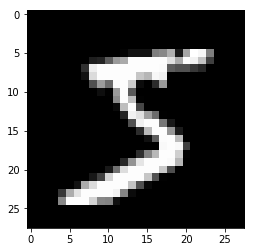

In [12]:
plt.imshow(img.view((28, 28)))

Let's create a simple lineal model that will allow us to use matrix multiplication y = ax+b

the 'a' will be our weights. This will be of size 784 because that's our input size by 10 because that's our ouput size

In [13]:
weights = torch.rand(784, 10)

In [14]:
bias = torch.rand(10)

Now let's get into the matrix multiplication part.

### Matmul attempt 1:

In [15]:
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac == br
    
    c = torch.zeros(ar, bc)
    
    for i in range(ar):
        for j in range(bc):
            for k in range(ac):
                c[i][j] += a[i][k] * b[k][j]
    return c

In [16]:
m1 = x_valid[:5]
m2 = weights

In [17]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [18]:
%time t1 = matmul(m1, m2)

CPU times: user 972 ms, sys: 0 ns, total: 972 ms
Wall time: 971 ms


So as we can see, this took about a second, let's see if we can make it any better

In [19]:
t1.shape

torch.Size([5, 10])

### Matmul attempt 2:

Let's try to optimize our previous attempt by  using pytorch (which doesn't use python) by using element wise operations.

In [20]:
a = tensor([10, 6, -4])
b = tensor([2, 8, 7])

In [21]:
a + b #this is a elemt wise addition

tensor([12, 14,  3])

In [22]:
(a<b).float().mean()

tensor(0.6667)

We can also do element wise operations on rank 2 tensors as well

In [23]:
m = tensor([[1., 2., 3.],[4., 5., 6.],[7., 8., 9.]])

Let's calculate the forbenious norm:
$\|A\|_\text{F} = \sqrt{\sum_{i=1}^m \sum_{j=1}^n |a_{ij}|^2}$


In [24]:
(m*m).sum().sqrt()

tensor(16.8819)

Element wise matmul which will run the most nested line in C code

In [25]:
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac == br
    
    c = torch.zeros(ar, bc)
    
    for i in range(ar):
        for j in range(bc):
            c[i, j] = (a[i, :] * b[:, j]).sum()
    return c

In [26]:
m1 = x_valid[:5]
m2 = weights


print((m1[0, :]).shape)
print((m1[:, 0]).shape)

%timeit -n 10  _=matmul(m1, m2)

t2 = matmul(m1, m2)

torch.Size([784])
torch.Size([5])
1.61 ms ± 24.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [27]:
def near(a, b): return torch.allclose(a, b, rtol=1e-3, atol=1e-5)
def test_near(a, b): test(a, b, near)

In [28]:
test_near(t1, t2)

### Matmul attempt 3: Broadcasting

Broadcasting is the most powerful tool in our toolbox for writting code in python that runs at C speed or at CUDA if we are using pytorch using a GPU and pytorch.

In [29]:
a

tensor([10,  6, -4])

In [30]:
a > 0

tensor([ True,  True, False])

How does the above work?

Well what happens is tha that the scalar becomes a tensor of [0, 0, 0] then it's compared. This is broadcasting.

In [31]:
a = a*2

We can also broadcast a vector to a matrix:

In [32]:
c = tensor([10., 20., 30.])

In [33]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [34]:
m.shape, c.shape

(torch.Size([3, 3]), torch.Size([3]))

In [35]:
m + c

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

What happened was a broadcast of the x row to every row of the m matrix.

Now, we don't really copy the rows but it looks as if we did. In fact the rows are given a stride 0.

In [36]:
t =  c.expand_as(m)

In [37]:
t

tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])

In [38]:
m + t

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

Now we might be worrying tho that this looks memory intensive, however we shouldn't. We can actually look inside the memory used by pytorch:

In [39]:
t.storage()

 10.0
 20.0
 30.0
[torch.FloatStorage of size 3]

In [40]:
t.stride(), t.shape

((0, 1), torch.Size([3, 3]))

As we can see, it knows the shape it's meant to be (3 by 3) but has a stride of (0, 1). This (0, 1) means that when it goes from row to row it's mean't to take 0 steps but when it goes from column to column it's meant to go 1 step.

Now, what happens if we want to take a column instead of a row?

We can create a rank 2 tensor of shape (3, 1) from a rank 1 tensor using the *unsqueze* funtion which adds one dimension (axis) wherever we ask:

In [41]:
c

tensor([10., 20., 30.])

In [42]:
c.unsqueeze(0)

tensor([[10., 20., 30.]])

In [43]:
c.unsqueeze(1)

tensor([[10.],
        [20.],
        [30.]])

In [44]:
c.shape, c.unsqueeze(0).shape, c.unsqueeze(1).shape

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]))

Now, using unsqueeze is a bit clunky, we can rather better use the None trick:

In [45]:
c.shape, c[None, :].shape, c[:, None].shape

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]))

We can always skip the ":"s. And "..." means 'all preceding dimensions'

In [46]:
c.shape, c[None].shape, c[..., None].shape

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]))

Now something interesting is that we can now expand our c vector not in a row ish shape but rather in a column issh shape

In [47]:
print(c)
print(c.expand_as(m))
print(c[:, None].expand_as(m))

tensor([10., 20., 30.])
tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])
tensor([[10., 10., 10.],
        [20., 20., 20.],
        [30., 30., 30.]])


In [48]:
m + c[:, None]

tensor([[11., 12., 13.],
        [24., 25., 26.],
        [37., 38., 39.]])

So what's happening is that we are taking the unit axis and expanding over it.

We can use that now to get rid of our loop:

In [49]:
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac == br
    
    c = torch.zeros(ar, bc)
    
    for i in range(ar):
        c[i, :] = (a[i, :].unsqueeze(-1) * b).sum(dim=0)
    return c

In [50]:
%timeit -n 10 _ = matmul(m1, m2)
t3 = matmul(m1, m2)

325 µs ± 7.37 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [51]:
test_near(t3, t1)

As we can see this is way faster.

In [52]:
a = tensor([[1, 2, 3],[4, 5, 6],[7, 8, 9]])
a

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])

In [53]:
b = tensor([[1, 3],[4, 5],[8, 9]])
b


tensor([[1, 3],
        [4, 5],
        [8, 9]])

In [54]:
a@b

tensor([[ 33,  40],
        [ 72,  91],
        [111, 142]])

In [55]:
(a[0, :].unsqueeze(1) * b).sum(dim=1)

tensor([ 4, 18, 51])

#### Broadcasting in bigger dimension tensors:

In [56]:
x = tensor([1, 2, 3])

In [57]:
a = x[:, None]
print(a.shape)
a

torch.Size([3, 1])


tensor([[1],
        [2],
        [3]])

In [58]:
b = x[None, :]
print(b.shape)
b

torch.Size([1, 3])


tensor([[1, 2, 3]])

In [59]:
a * b

tensor([[1, 2, 3],
        [2, 4, 6],
        [3, 6, 9]])

**The rules are simple:**

Any library that supports tensors will basically compare their shapes element-wise. It starts with the trailing (last) dimensions and works it's way forward. 2 dimensions are compatible when:

- they are equal or
- one of them is 1, in which case that timension is broadcasted to make it the same size


Now, tensors don't neccesarily have to be the same rank:

- Image:  256, 256, 256
- Scale:          ,   3
- Result: 256, 256, 256


What it does is that anywhere where there's a missing dimenion it inserts a 1 there (leading dimensions)


### Matmul attempt 4: Einstein summation

Let's retake atempt 1:

In [60]:
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac == br
    
    c = torch.zeros(ar, bc)
    
    for i in range(ar):
        for j in range(bc):
            for k in range(ac):
                c[i][j] += a[i][k] * b[k][j]
    return c

Let's retake atempt 2:

In [61]:
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac == br
    
    c = torch.zeros(ar, bc)
    
    for i in range(ar):
        for j in range(bc):
            c[i, j] = (a[i, :] * b[:, j]).sum()
    return c

Innermost part a1:

    c[i,j] += a[i, k] * b[k, j]

Innermost part a2:

    c[i,j] = (a[i, :] * b[:, j]).sum()


As we can see, basically the difference is that the repeated *k* got replaced with a column
    
Now check this, lets:

- Let's take our a1 approach and change the assignation to the right
- Let's get rid of the variable names
- Let's get rid of the commas
- Let's replace spaces with commas

      ik,kj->ij
      
This is what we call the **einstein summation notation**, we should notice that:

- Left of arrow: input
- Right of arrow: output
- How many dimensions? = How many letters?
- How big inputs? *(i * k), (k * j) -> (i * j)*
- When we see the same letter appearing in different places we are reffering to the same dimension
- What happens with the k? We look for any place where the letter was repeated and we do a dot product on that dimension (like in the second attempt)

In [62]:
def matmul(a, b): return torch.einsum('ik,kj->ij', a, b)

In [63]:
%timeit -n 10 matmul(m1, m2)
t4 = matmul(m1, m2)

59.8 µs ± 16.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [64]:
test_near(t4, t1)

### Matmul Pytorch

In [65]:
%timeit -n 10 t5 = m1.matmul(m2)

10.7 µs ± 4.61 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


@ also thoes the trick but it also covers a much borader array of tensor reductions across different levels of axis.

In [66]:
t5 = m1 @ m2

In [67]:
test_near(t5, t1)

So what makes this so fast?

Well, what happens when we are multiplying huge matrices and columns this are things that can't be cached in our CPU so our CPU has to be pulling data from RAM over and over again which is slow. So that pytorch does is that it does this subsections of matrix multiplications within our matrix to keep the data chached and retrieve it from RAM fewer times.

## Forward pass

Now that we have the matrix multiplication implemented we can start implementing the forward pass from our NN.

In [68]:
def normalize(x, m, s): return (x-m)/s

In [69]:
train_mean, train_std = x_train.mean(), x_train.std()
train_mean, train_std

(tensor(0.1304), tensor(0.3073))

Notice that we want to have a 0 mean and a 1 std.

In [70]:
x_train = normalize(x_train, train_mean, train_std)
x_valid = normalize(x_valid, train_mean, train_std)

After doing that we have a mean very close to 0 and a std deviation very close to 1.

In [71]:
x_train.mean(), x_train.std(), x_valid.mean(), x_valid.std()

(tensor(-3.0466e-06), tensor(1.), tensor(-0.0059), tensor(0.9924))

In [72]:
def test_near_zero(a, tol=1e-3): assert a.abs()<tol, f"Near zero: {a}"

In [73]:
test_near_zero(x_train.mean())
test_near_zero(1-x_train.std())

In [74]:
n, m = x_train.shape
c = y_train.max()+1
n, m, c

(50000, 784, tensor(10))

### Foundations Version

Let's implement a NN with one hidden layer and a final ouput with 10 activations to which we will apply corssentropy. But to simplify things for now we will use MSE which isn't the best choice here.

In [75]:
# hidden size
nh = 50

In [76]:
# hidden
w1 = torch.randn(m, nh)
b1 = torch.zeros(nh)

#output
w2 = torch.rand(nh, 1)
b2 = torch.zeros(1)

So our inputs are already mean 0, std dev 1. However we also want our inputs to the second layer to be mean 0, std dev 1. How are we going to do that?

Let's see what will be our mean and std:

In [77]:
def lin(x, w, b): return x@w + b

In [78]:
t = lin(x_valid, w1, b1)
t.mean(), t.std()

(tensor(-2.2694), tensor(28.6039))

As we can see, this is not what we actually want so let's try something else:

Let's do a simplified version of the kaiming init / he init. 

By default our weigths will give us a mean 0, std deviation of one, so if we devide them by the sqrt(number of rows) we will end up with a mean 0 but a std deviation of 1/sqrt(m).

So in general numbers with mean 0 and std deviation of 1/sqrt(m) will give us an output of 0, 1 when doing the matmul.

**How is this helpful?** Well this seems like a minimal modification but this is like the thing that matters when triaing neural nets. This is a way of normalizing the initialization of the weigths.

In [79]:
# hidden
w1 = torch.randn(m, nh)/math.sqrt(m)
b1 = torch.zeros(nh)

#output
w2 = torch.rand(nh, 1)/math.sqrt(nh)
b2 = torch.zeros(1)

In [80]:
t = lin(x_valid, w1, b1)
t.mean(), t.std()

(tensor(-0.0599), tensor(0.9733))

As we can see we are very close to 0 mean and 1 std dev.

Now let's define our linear function and our reul function:

In [81]:
def lin(x, w, b): return x@w + b

In [82]:
def relu(x): return x.clamp_min(0.)

In [83]:
t = relu(lin(x_valid, w1, b1))

In [84]:
t.mean(), t.std()

(tensor(0.3580), tensor(0.5443))

Unfortunately the above function doesn't have a mean of 0 neither a std deviation of 1, why?
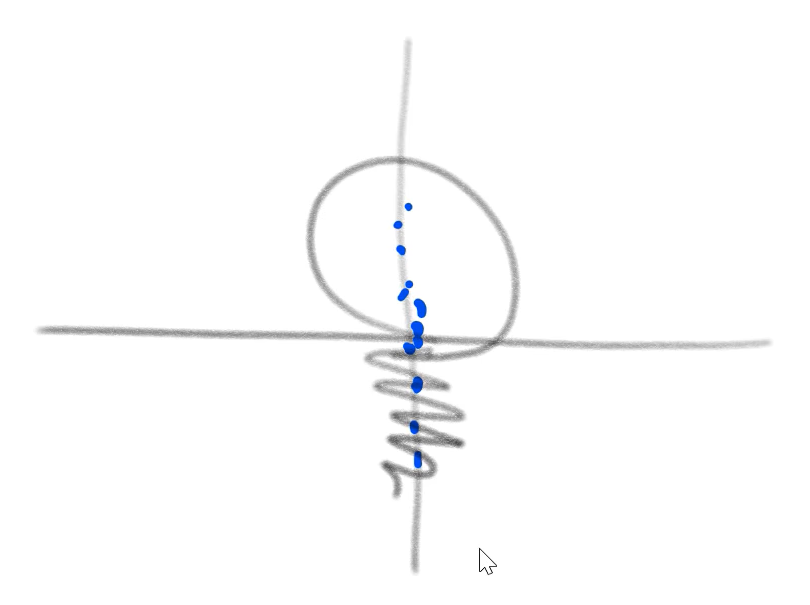

That's what happened so basically our mean is now not 0 and our std deviation is approximately half what it used to be.

### Notes on initialization paper

### Foundations version continue

In [85]:
# kaming init / he init for relu:

# hidden
w1 = torch.randn(m, nh)*math.sqrt(2/m)
b1 = torch.zeros(nh)

#output
w2 = torch.rand(nh, 1)*math.sqrt(2/nh)
b2 = torch.zeros(1)

In [86]:
w1.mean(), w1.std()

(tensor(-0.0002), tensor(0.0505))

In [87]:
t = relu(lin(x_valid, w1, b1))

In [88]:
t.mean(), t.std()

(tensor(0.5457), tensor(0.8213))

As we can see our mean is about .5 and not 0. Also our std tends to 1 but it sort of sticks around .8. Let's make our mean and reduce 0.5 from it.

In [89]:
def relu(x): return x.clamp_min(0.) - 0.5

In [90]:
t = relu(lin(x_valid, w1, b1))

In [91]:
t.mean(), t.std()

(tensor(0.0457), tensor(0.8213))

So now that we have the "correct" mean of 0. Now that we have the formula we can use pytorch's implementation: *init.kaming_normal_*

In [92]:
from torch.nn import init

In [93]:
# hidden
w1 = torch.randn(m, nh)
init.kaiming_normal_(w1, mode='fan_out')
b1 = torch.zeros(nh)

#output
w2 = torch.rand(nh, 1)
init.kaiming_normal_(w2, mode='fan_out')
b2 = torch.zeros(1)

In [94]:
t = relu(lin(x_valid, w1, b1))

In [95]:
w1.mean(), w1.std()

(tensor(-0.0003), tensor(0.0504))

In [96]:
t.mean(), t.std()

(tensor(0.0429), tensor(0.8159))

Something to notice is that we have "mode = fan_out" in our init.

What this means is:

- fan_in (default): preserves the magnitude of the variance of the weigths in the forward pass.
- fan_out: preserves the magnitudes in the backward pass.

Basically all it's saying is if we are dividing by root m (rows) or by rood(nh) columns. This is because in our backward pass to calculate the derivative of our linear funciton we are essentially multypling by our transposed matrix.

So for us is kind of weird to select *fan_out* since we currentl want a *fan_in*. The reason is the following:

In [97]:
import torch.nn

In [98]:
w2.shape

torch.Size([50, 1])

In [99]:
torch.nn.Linear(m, nh).weight.shape

torch.Size([50, 784])

When creating a *pytorhc* Linear layer of m (input = 784) by nh (output = 50) what we are actually getting is a matrix of (nh * m) instead of (m * nh).

How is this working tho?

Well let's look into the source code:

In [100]:
torch.nn.Linear.forward??

In [101]:
torch.nn.functional.linear??

As we can see, we are actually transposing the weight matrix so we do end up with a weight matrix of size (m * nh) *on the multiplication*. So that's why we give it sort of the opposite information.

This also then leads the question: How do we apply this to convolutional layers weigths?

In [102]:
torch.nn.Conv2d??

In [103]:
torch.nn.modules.conv._ConvNd.reset_parameters??

As we can see we are actually also calling *kaiming_unigorm* instead of *kaiming_normal* which is basically the same thing but with a uniform distribution instead but it has a special multiplier of sqrt(5) which is not documented anywhere. This seems to work pretty badly for some reason.

Now that we have matmul, linear, relu and init we can do a NN.

In [104]:
def model(xb):
    l1 = lin(xb, w1, b1)
    l2 = relu(l1)
    l3 = lin(l2, w2, b2)
    return l3

In [105]:
%timeit -n 10 _=model(x_valid)

2.57 ms ± 800 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [106]:
assert model(x_valid).shape == torch.Size([x_valid.shape[0], 1])

### Loss function: MSE

So the next thing we need after our forward pass is a loss function. Let's use MSE by now.

In [107]:
model(x_valid).shape

torch.Size([10000, 1])

In [108]:
def mse(output, targ): return (output.squeeze(1) - targ).pow(2).mean()

As we can see above we use the *squeeze* function to flatten our column vector ouput and then we do the MSE.

In [109]:
y_train, y_valid = y_train.float(), y_valid.float()

In [110]:
preds = model(x_train)

In [111]:
preds.shape

torch.Size([50000, 1])

In [112]:
mse(preds, y_train)

tensor(22.7565)

## Backward pass

A forward pass is useless without a backward pass that tells us how to update our parametes, so we need gradients.

In [113]:
def mse_grad(inp, targ):
    #grad of loss with respect to ouput of previous layer
    inp.g = 2. * (inp.squeeze() - targ).unsqueeze(-1) / inp.shape[0]

In [114]:
def relu_grad(inp, out):
    inp.g = (inp > 0).float() * out.g

In [115]:
def lin_grad(inp, out, w, b):
    inp.g = out.g @ w.t()
    w.g = (inp.unsqueeze(-1) * out.g.unsqueeze(1)).sum(0)
    b.g = out.g.sum(0)

In [116]:
def forward_and_backward(inp, targ):
    # forward
    l1 = inp @ w1 + b1
    l2 = relu(l1)
    out = l2 @ w2 + b2
    loss = mse(out, targ)
    
    # backward
    mse_grad(out, targ)
    lin_grad(l2, out, w2, b2)
    relu_grad(l1, l2)
    lin_grad(inp, l1, w1, b1)

In [117]:
forward_and_backward(x_train, y_train)

So basically this is a full forward an backward pass. We are storing the gradients to use them for the optimizer.

In [118]:
w1g = w1.g.clone()
w2g = w2.g.clone()
b1g = b1.g.clone()
b2g = b2.g.clone()
ig = x_train.g.clone()

Let's use pytorch autograd for testing

In [119]:
xt2 = x_train.clone().requires_grad_(True)
w12 = w1.clone().requires_grad_(True)
w22 = w2.clone().requires_grad_(True)
b12 = b1.clone().requires_grad_(True)
b22 = b2.clone().requires_grad_(True)

In [120]:
def forward(inp, targ):
    #forward
    l1 = inp @ w12 + b12
    l2 = relu(l1)
    out = l2 @ w22 + b22
    #we don't actually need the loss in backward so we don't calculate it unless we want to print it
    return mse(out, targ)

In [121]:
loss = forward(xt2, y_train)

In [122]:
loss.backward()

In [123]:
test_near(w1g, w12.grad)
test_near(w2g, w22.grad)
test_near(b1g, b12.grad)
test_near(b2g, b22.grad)
test_near(ig, xt2.grad)

As we can see all of our gradients are correct here above

## Refactoring all

We will be using the *__call__* to make sure that we can call our class as a function

In [124]:
class Relu():
    def __call__(self, inp):
        self.inp = inp
        self.out = inp.clamp_min(0.)-0.5
        return self.out
    
    def backward(self): self.inp.g = (self.inp>0).float() * self.out.g

In [125]:
class Lin():
    def __init__(self, w, b): self.w, self.b = w, b
    
    def __call__(self, inp):
        self.inp = inp
        self.out = inp @ self.w + self.b
        return self.out
    
    def backward(self):
        self.inp.g = self.out.g @ self.w.t()
        self.w.g = (self.inp.unsqueeze(-1) * self.out.g.unsqueeze(1)).sum(0)
        self.b.g = self.out.g.sum(0)

In [126]:
class Mse():
    def __call__(self, inp, targ):
        self.inp = inp
        self.targ = targ
        self.out = (inp.squeeze() - targ).pow(2).mean()
        return self.out
    
    def backward(self):
        self.inp.g = 2. * (self.inp.squeeze() - self.targ).unsqueeze(-1) / self.targ.shape[0]

In [127]:
class Model():
    def __init__(self, w1, b1, w2, b2):
        self.layers = [Lin(w1, b1), Relu(), Lin(w2, b2)]
        self.loss = Mse()
  
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return self.loss(x, targ)
    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers): l.backward()

In [128]:
w1.g, b1.g, w2.g, b2.g = [None]*4
model = Model(w1, b1, w2, b2)

In [129]:
%time loss = model(x_train, y_train)

CPU times: user 116 ms, sys: 4 ms, total: 120 ms
Wall time: 15.1 ms


In [130]:
%time model.backward()

CPU times: user 4.94 s, sys: 5.44 s, total: 10.4 s
Wall time: 1.4 s


In [131]:
test_near(w1g, w1.g)
test_near(w2g, w2.g)
test_near(b1g, b1.g)
test_near(b2g, b2.g)
test_near(ig, x_train.g)

## Refactor even more

There's a lot of repetitive code so let's make it less repeptitive:

In [132]:
class Module():
    def __call__(self , *args):
        self.args = args
        self.out = self.forward(*args)
        return self.out
    
    def forward(self): raise Exception('not implemented')
    def backward(self): self.bwd(self.out, *self.args)

In [133]:
class Relu(Module):
    def forward(self, inp): return inp.clamp_min(0.)-0.5
    def bwd(self, out, inp): inp.g = (inp > 0).float() * out.g

In [134]:
class Lin(Module):
    def __init__(self, w, b): self.w, self.b = w, b
    
    def forward(self, inp):
        return inp @ self.w + self.b
    
    def bwd(self, out, inp):
        inp.g = self.out.g @ self.w.t()
        self.w.g = inp.t() @ out.g
        self.b.g = self.out.g.sum(0)

In [135]:
class Mse():
    def __call__(self, inp, targ):
        self.inp = inp
        self.targ = targ
        self.out = (inp.squeeze() - targ).pow(2).mean()
        return self.out
    
    def backward(self):
        self.inp.g = 2. * (self.inp.squeeze() - self.targ).unsqueeze(-1) / self.targ.shape[0]

In [136]:
class Model():
    def __init__(self, w1, b1, w2, b2):
        self.layers = [Lin(w1, b1), Relu(), Lin(w2, b2)]
        self.loss = Mse()
  
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return self.loss(x, targ)
    
    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers): l.backward()

In [137]:
w1.g, b1.g, w2.g, b2.g = [None]*4
model = Model(w1, b1, w2, b2)

In [138]:
%time loss = model(x_train, y_train)

CPU times: user 112 ms, sys: 0 ns, total: 112 ms
Wall time: 13.9 ms


In [139]:
%time model.backward()

CPU times: user 268 ms, sys: 148 ms, total: 416 ms
Wall time: 52.4 ms


In [140]:
test_near(w1g, w1.g)
test_near(w2g, w2.g)
test_near(b1g, b1.g)
test_near(b2g, b2.g)
test_near(ig, x_train.g)

## Using pytorch's implementation

In [141]:
from torch import nn

In [147]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]
        self.loss = mse
        
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return self.loss(x, targ)

In [148]:
model = Model(m, nh ,1)

In [152]:
%time loss = model(x_train, y_train)

CPU times: user 116 ms, sys: 48 ms, total: 164 ms
Wall time: 23.6 ms


In [153]:
%time loss.backward()

CPU times: user 292 ms, sys: 164 ms, total: 456 ms
Wall time: 62.8 ms


## Testing

In [ ]:
a = [[10.],
    [20.]]
b = [42., 8.]

a,b = tensor(a), tensor(b)
mse_grad(a, b)

In [ ]:
(a.squeeze() - b).unsqueeze(-1)

In [ ]:
x_train.shape

In [ ]:
a = tensor([[1, 2, 3],[4, 5, 6],[7, 8, 9]])

In [ ]:
a

In [ ]:
a.unsqueeze(-1)

In [ ]:
b = tensor([[2],[4],[8]])
b.unsqueeze(1)

In [ ]:
a.unsqueeze(-1) * b.unsqueeze(1)

In [ ]:
a.unsqueeze(-1).shape, b.unsqueeze(1).shape

In [ ]:
(a.unsqueeze(-1) * b.unsqueeze(1)).sum(0)

In [151]:
mse??